In [2]:
import json
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, GenerationConfig
from datasets import load_from_disk, concatenate_datasets
from tqdm.auto import tqdm
import torch

In [123]:
max_input = 1024
max_target = 256
model_checkpoint = "../models/BART-SFT-r1/checkpoint-4200/"

In [124]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [4]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerN

In [40]:
generation_config = GenerationConfig.from_pretrained(model_checkpoint)
generation_config

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 142,
  "min_length": 56,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}

In [108]:
raw_datasets = load_from_disk("../data/hf_dataset")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['summary', 'article', 'article_bias', 'id', 'summary_bias'],
        num_rows: 4664
    })
    validation: Dataset({
        features: ['summary', 'article', 'article_bias', 'id', 'summary_bias'],
        num_rows: 542
    })
    test: Dataset({
        features: ['summary', 'article', 'article_bias', 'id', 'summary_bias'],
        num_rows: 602
    })
})

In [24]:
def preprocess_data(examples):
    # get all the articles, prepend each with "bias;"
    inputs = [
        f"{bias}; {article}"
        for bias, article in zip(examples["summary_bias"], examples["article"])
    ]
    # tokenize the inputs
    model_inputs = tokenizer(
        inputs, max_length=max_input, padding="max_length", truncation=True
    )

    # tokenize the summaries, set max_length to longest summary (vs 128 in training)
    targets = tokenizer(
        examples["summary"],
        max_length=None,
        padding=False,
        truncation=False,
        # return_tensors="pt"
    )

    # set labels
    model_inputs["labels"] = targets["input_ids"]
    # return the tokenized data
    # input_ids, attention_mask and labels
    return model_inputs

In [25]:
tokenized_data = raw_datasets.map(preprocess_data, batched=True)

Map:   0%|          | 0/4664 [00:00<?, ? examples/s]

Map:   0%|          | 0/542 [00:00<?, ? examples/s]

Map:   0%|          | 0/602 [00:00<?, ? examples/s]

In [26]:
tokenizer.decode(tokenized_data["test"][0]['input_ids'], skip_special_tokens=True) # example input

'left; U.S. House condemns \'QAnon\' conspiracy theory; 17 Republicans vote no\nWASHINGTON (Reuters) - The U.S. House of Representatives on Friday voted to condemn the online pro-Trump conspiracy theory known as "QAnon," but 17 Republicans opposed the non-binding resolution, whose sponsor Democrat Representative Tom Malinowski said he has received death threats.\nThe House voted 371-18 to reject the conspiracy theory, which posits President Donald Trump has been working to take down a global child sex ring. As many as a dozen Republican candidates for Congress have voiced some support for the theory, and at least one of them appears to be a on a path to victory.\n"The grotesque nature of the tweets and Instagram posts and the anti-Semitic tripe spewed by QAnon adherents should cause concern for everyone," Representative Denver Riggleman, a Republican co-sponsor of the resolution, said on the House floor.\n"But the death threats Tom Malinowski received were at surprise and a shock," Rig

In [54]:
outputs = []
for ex in tqdm(concatenate_datasets([tokenized_data['train'], tokenized_data['validation']])):
    # Generate output with temperature 0.7
    out = model.generate(torch.tensor(ex['input_ids']).unsqueeze(0).to(device),
                             max_length=max_target,
                             temperature=0.7,
                             attention_mask=torch.tensor(ex['attention_mask']).unsqueeze(0).to(device),
                             do_sample=True,
                             generation_config=generation_config)
    text = tokenizer.decode(out[0].cpu(), skip_special_tokens=True)
    ex['output_0.7'] = text
    
    # temp 1.2
    out = model.generate(torch.tensor(ex['input_ids']).unsqueeze(0).to(device),
                             max_length=max_target,
                             temperature=1.2,
                             attention_mask=torch.tensor(ex['attention_mask']).unsqueeze(0).to(device),
                             do_sample=True,
                             generation_config=generation_config)
    text = tokenizer.decode(out[0].cpu(), skip_special_tokens=True)
    ex['output_1.2'] = text

    del ex['input_ids']
    del ex['attention_mask']
    del ex['labels']
    outputs.append(ex)

  0%|          | 0/5206 [00:00<?, ?it/s]

In [59]:
outputs[0]

{'summary': "National park employees in the US are concerned about people continuing to visit parks amidst the coronavirus outbreak and potentially spreading the virus further. The Centers for Disease Control and Prevention is poised to issue guidance on behaviour in parks, but many workers are worried. An employee at the Klondike Gold Rush National Historical Park in Alaska quit his job over ongoing concerns about social distancing, and President Trump's decision to waive entrance fees to encourage outdoor activities did not help to lower his anxieties. Workers at the Grand Canyon National Park were similarly concerned after seeing visitor numbers rise, and have asked for permission to close.",
 'article': 'Appeals grow to close US national parks during pandemic\nWASHINGTON (AP) — The Trump administration is sticking with its crowd-friendly waiver of entrance fees at national parks during the coronavirus pandemic, as managers at some parks try and fail to keep visitors a safe distance

In [57]:
with open("model_outputs.json", "w+") as f:
    json.dump(outputs, f)

## rouge

In [106]:
with open('model_outputs.json') as f:
    outputs = json.load(f)

In [114]:
from evaluate import load

[2023-12-14 03:56:03,504] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [115]:
import nltk
import numpy as np
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/andrew/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [116]:
metric = load('rouge')

In [117]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Rouge expects a newline after each sentence
    decoded_preds = [
        "\n".join(nltk.sent_tokenize(pred.strip())) for pred in predictions
    ]
    decoded_labels = [
        "\n".join(nltk.sent_tokenize(label.strip())) for label in labels
    ]

    # Note that other metrics may not have a `use_aggregator` parameter
    # and thus will return a list, computing a metric for each sentence.
    result = metric.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,
        use_aggregator=True,
    )
    # Extract a few results
    result = {key: value * 100 for key, value in result.items()}

    # Add mean generated length
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
    ]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [118]:
preds7 = []
preds12 = []
labels = []
for item in outputs:
    preds7.append(item['output_0.7'])
    preds12.append(item['output_1.2'])
    labels.append(item['summary'])

In [119]:
len(outputs)

5206

In [126]:
compute_metrics((preds7[:-542], labels[:-542])) # train

INFO:absl:Using default tokenizer.


{'rouge1': 45.9246,
 'rouge2': 18.9384,
 'rougeL': 28.0519,
 'rougeLsum': 41.1079,
 'gen_len': 1.0}

In [125]:
compute_metrics((preds7[-542:], labels[-542:])) # validation

INFO:absl:Using default tokenizer.


{'rouge1': 42.8796,
 'rouge2': 14.9425,
 'rougeL': 24.5125,
 'rougeLsum': 37.9773,
 'gen_len': 1.0}

In [129]:
compute_metrics((preds12[:-542], labels[:-542])) # train

INFO:absl:Using default tokenizer.


{'rouge1': 45.7197,
 'rouge2': 18.484,
 'rougeL': 27.5959,
 'rougeLsum': 40.8723,
 'gen_len': 1.0}

In [130]:
compute_metrics((preds12[-542:], labels[-542:])) # validation

INFO:absl:Using default tokenizer.


{'rouge1': 42.7987,
 'rouge2': 14.6372,
 'rougeL': 24.3514,
 'rougeLsum': 37.7771,
 'gen_len': 1.0}

In [137]:
compute_metrics((preds7, preds12)) # model output differences

INFO:absl:Using default tokenizer.


{'rouge1': 68.8417,
 'rouge2': 49.8581,
 'rougeL': 53.6847,
 'rougeLsum': 65.3709,
 'gen_len': 1.0}

### stats

In [132]:
preds7_tok = [len(tokenizer.encode(p)) for p in preds7]
preds12_tok = [len(tokenizer.encode(p)) for p in preds12]

In [133]:
np.mean(preds7_tok)

154.5662696888206

In [135]:
max(preds7_tok), min(preds7_tok)

(239, 65)

In [136]:
np.mean(preds12_tok), max(preds12_tok), min(preds12_tok)

(155.02401075681905, 238, 65)

In [58]:
import matplotlib.pyplot as plt

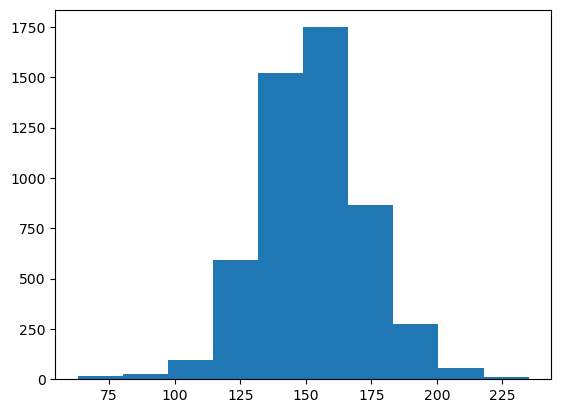

In [62]:
plt.hist(preds7_tok)
plt.show()

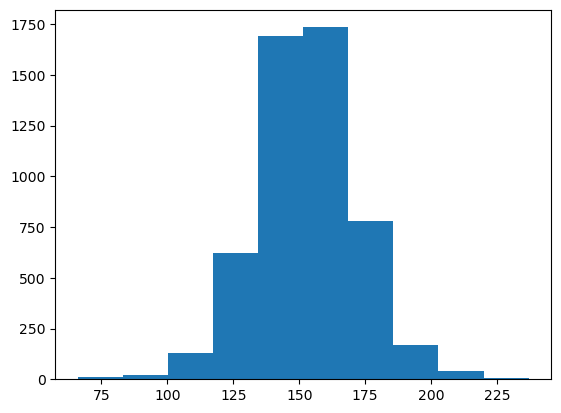

In [63]:
plt.hist(preds12_tok)
plt.show()

# AlpacaFarm-ish annotate

In [92]:
from alpaca_eval.utils import make_prompts
import pandas as pd
import numpy as np

In [7]:
outputs_pairs = [{
    'instruction': f"Pretend you have {item['summary_bias']} leaning political views. Summarize the article:",
    # 'input': encoder.decode(encoder.encode(item['article'])[:512]), # truncate article to 512 tokens
    'input': item['article'],
    'output_1': item['output_0.7'],
    'output_2': item['output_1.2']
} for item in outputs]

In [49]:
df = pd.DataFrame.from_records(outputs_pairs)

In [50]:
df.head()

,instruction,input,output_1,output_2
0,Pretend you have left leaning political views....,Appeals grow to close US national parks during...,The Trump administration is continuing to waiv...,The Trump administration is continuing to waiv...
1,Pretend you have left leaning political views....,Thousands are crowding into free national park...,The Trump administration’s decision to waive e...,The National Park Service (NPS) has been criti...
2,Pretend you have left leaning political views....,National Park Service asks people to practice ...,The National Park Service (NPS) has urged visi...,The National Park Service (NPS) has urged visi...
3,Pretend you have left leaning political views....,U.S. appeals court to take up constitutionalit...,A US federal appeals court in New Orleans is s...,A federal appeals court in the US has begun he...
4,Pretend you have left leaning political views....,Long-shot legal challenge could end Obamacare ...,A federal appeals court in New Orleans is set ...,A federal appeals court in New Orleans is set ...


In [46]:
with open('annotator_prompt.txt') as f:
    template = f.read()

In [51]:
prompts, df_out = make_prompts(df[:-1], template, batch_size=5)

In [52]:
with open("gpt4-api2.jsonl", 'w+') as f:
    for idx, prompt in enumerate(prompts[464:]):
        d = dict(model="gpt-4-1106-preview", messages=[{"role": "user", "content": prompt}], metadata={'id': idx})
        json_record = json.dumps(d)
        f.write(json_record + '\n')

## convert api outputs to comparisons dataset

In [3]:
with open("gpt4-api-output.jsonl") as f:
    lines = f.readlines()
    api_responses = [json.loads(l) for l in lines]

In [59]:
with open("gpt4-api-output2.jsonl") as f:
    lines = f.readlines()
    api_responses2 = [json.loads(l) for l in lines]

In [89]:
all_responses = api_responses + api_responses2

In [90]:
ids = set()
bad_ids = set()
for item in all_responses:
    try:
        outputs = item[1]['choices'][0]['message']['content'].split('\n')
        ids.add(item[2]['id'])
    except:
        # bad_ids.add(item[2]['id'])
        pass

In [96]:
good_responses = [r for i, r in enumerate(all_responses) if i in ids]

In [99]:
comparisons_dicts = []
for i, item in enumerate(api_responses[:464]):
    index = item[2]['id'] * 5
    indexes = list(range(index, index + 5))
    try:
        annotations = item[1]['choices'][0]['message']['content'].split('\n')
    except:
        print(i)
    assert(len(indexes) == len(annotations))
    
    for j, idx in enumerate(indexes):
        instruction, input, output1, output2 = list(outputs_pairs[idx].values())
        prompt = instruction + '\n' + input
        if annotations[j] == "Output (a)":
            chosen = output1
            rejected = output2
        elif annotations[j] == "Output (b)":
            chosen = output2
            rejected = output1
        else:
            print("SOMETHING IS WRONG")

        comparisons_dicts.append(dict(prompt=prompt, chosen=chosen, rejected=rejected))

In [101]:
comparisons_dataset = pd.DataFrame.from_records(comparisons_dicts)

In [104]:
comparisons_dataset.to_csv("comparisons_dataset.csv", index=False)